# ESA CCI Biomass V5.01 — Access and Visualization (Token-secured)

Authors: Rajat Shinde (UAH), Alex Mandel (Development Seed), Sheyenne Kirkland (UAH), Harshini Girish (UAH), Jamison French (Development Seed), Henry Rodman (Development Seed), Chuck Daniels (Development Seed), Zac Deziel (Development Seed), Brian Freitag (NASA)

Date: August 22, 2025

Description: This notebook documents how to access and visualize the ESA CCI Biomass V5.01 dataset hosted on the ESA MAAP server. It is an example illustrtaing data access from ESA server based on ESA MAAP Token using the NASA MAAP Authorization.

---

## What you will do
1. Understand the product and file organization.  
2. Obtain an ESA access token.  
3. Access a V5.01 raster using the token.  
4. Visualize in Python.  

---

## Run this notebook
You can run this notebook in your MAAP environment:
- Click on the **Launch Notebook** button from the documentation page, or  
- Clone this notebook to your workspace and run all cells in order.  

**Prerequisites**  
- An active ESA MAAP portal account with access initialized.  
- OAuth2 client credentials for your ESA realm.  
- Python packages: `requests`, `rasterio`, `numpy`, `matplotlib` (optional: `pystac-client`, `stackstac`).  


## Importing and Installing Packages

In [3]:
# Install if needed. Comment out if already available.
# !mamba install -y -c conda-forge rasterio xarray matplotlib fsspec requests
# !pip install pystac-client stackstac

import os
import requests
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.io import MemoryFile

plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams["axes.grid"] = False

## Getting the Token from the ESA MAAP portal

This explains how to retrieve a short-lived access token from the ESA MAAP portal using your browser and NASA EDL login.

Open the token page in your browser:
**https://portal.maap.eo.esa.int/ini/services/auth/token/**

**Steps**
1. Navigate to the URL above.  
2. Choose **NASA Earthdata Login (EDL)** when prompted and authorize access.  
3. After successful authorization you will see a **token page** showing your short‑lived access token string.

**The below screenshots illustrate the process for each steps.**
- **Portal entry page**:  
  ![Portal](./images/esa_maap.jpg)
- **NASA EDL authorization screen**:  
  ![NASA EDL](./images/page2.jpg)
- **Token page after authorization**:  
  ![Token Page](./images/page3.jpg)

**Copy the token value** from the token page for use in the next cell.

**Notes**
- Tokens are short‑lived. If you see **401 Unauthorized** later, refresh the token using the same URL and update the value in the notebook.
- Treat tokens as secrets. Do not commit them to version control or share publicly.

Now we paste the token we got from the portal into the notebook so Python can use it in subsequent requests.


In [4]:
# Paste the token string you copied from the portal page.
# Option A: assign directly
ESA_TOKEN = "eyuhbGciOiKKSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJQXzJqUU50Y3QtOGR2cW1qVG5QWDVNc3BfT1Zid2lzVFlHbmFwM2tUWVdJIn0.eyJleHAiOjE3NTU4ODQ3OTgsImlhdCI6MTc1NTg0MTU5OCwianRpIjoiMWYyMjg2MWMtZWJjYy00NDFjLWFjOTYtOGViZDEwZDdhNDY5IiwiaXNzIjoiaHR0cHM6Ly9pYW0ubWFhcC5lby5lc2EuaW50L3JlYWxtcy9lc2EtbWFhcCIsInN1YiI6IjhkMjZjNGQzLWVmNzAtNDhiMC1iYWEwLWNmYjlkNDM5ODk0MCIsInR5cCI6IkJlYXJlciIsImF6cCI6ImVzYS1tYWFwLXBvcnRhbCIsInNpZCI6ImMyZmQyYjc2LTZiYTMtNDdlNS05YWQxLTViNTk0MjM5M2I1YiIsInNjb3BlIjoib3BlbmlkIiwic291cmNlcyI6WyJFT1A6RVNBOk1BQVAiLCJFT1A6RVNBOkVBUlRILU9OTElORS1OT1QtUkVBRFkiXSwiZ3JvdXBzIjpbIi9pbml0aWF0aXZlcy9iaW9tYXNzIiwiL2luaXRpYXRpdmVzL2Jpb21hc3Mvcm9sZXMvZGV2ZWxvcGVyIiwiL2V4cGxvcmVyIiwiL2luaXRpYXRpdmVzIl0sInByZWZlcnJlZF91c2VybmFtZSI6Im9tc2hpbmRlIiwiZW1haWwiOiJyczAxNzBAdWFoLmVkdSJ9.wmOuLGPeNAkb27lsrnGQo_QHXFWY1ILrTlH6VitIwz9lyjwQ6ps217oOIBs6Pak0IABzFRoWwM-g6ePlK0RUC7OPdn9iVsnr8D1aozzmgICrP2myxG37wbH7hMHDLZuQb2GYTQHMdFyarPVsC4XVfos5ouCBFkD2YDk1fTkbaynuAbECqGF8lMEgijv8gh13nJEFEMIdXPYoeG-1KZMIXcPBiPl3IZXtqtCQXhLbSU4yO99qeBPWaxHbK7GyAYdAbr076ip8YrAVNXo2vxVwcsO7yY78ZnvkJjv9sYl8cimaEGp2Rw4kR-on96tfc_1eDq-kg2vCEMg2PQ9f8JR_IA"

# Option B: set an environment variable externally and read it here
# ESA_TOKEN = os.environ.get("ESA_TOKEN")

if not ESA_TOKEN or ESA_TOKEN.startswith("<paste_"):
    raise ValueError("ESA_TOKEN is not set. Paste the token from the portal token page.")

## Testing Data Access

The below cell defines the URL of a specific tile in the Biomass V5.01 collection that we want to test access on.

In [5]:
# Replace with a tile you are authorized to access.
# This is an example pattern for a 2010 tile. Adjust path/year/tile as needed.
V5_EXAMPLE_URL = (
    "https://catalog.maap.eo.esa.int/"
    "data/biomass-maap-01/CCIBiomassV5.01/2010/01/01/"
    "N00E010_ESACCI-BIOMASS-L4-AGB-MERGED-100m-2010-fv5.0/"
    "N00E010_ESACCI-BIOMASS-L4-AGB-MERGED-100m-2010-fv5.0.tif"
)

print(V5_EXAMPLE_URL)

https://catalog.maap.eo.esa.int/data/biomass-maap-01/CCIBiomassV5.01/2010/01/01/N00E010_ESACCI-BIOMASS-L4-AGB-MERGED-100m-2010-fv5.0/N00E010_ESACCI-BIOMASS-L4-AGB-MERGED-100m-2010-fv5.0.tif


Here we make a request to the example tile using the token to check that authentication is working.

In [6]:
headers = {"Authorization": f"Bearer {ESA_TOKEN}"}
r = requests.get(V5_EXAMPLE_URL, headers=headers, stream=True)

print("HTTP status:", r.status_code)
if r.status_code == 403:
    print(
        "403 Forbidden: Your account may need initialization for this collection.\n"
        "Follow any initialization link provided by the server, refresh the token, and retry."
    )
elif r.status_code == 401:
    print("401 Unauthorized: Token expired or invalid. Get a new token at the portal URL and update ESA_TOKEN.")
elif r.status_code != 200:
    print("Unexpected status. Check URL, permissions, or try another tile/year.")
else:
    print("Access OK.")


HTTP status: 200
Access OK.


## Load the raster into memory and visualize

If access is successful, this cell reads the raster data in memory and plots a quicklook visualization.

Shape: (11250, 11250)
CRS: EPSG:4326
Transform: | 0.00, 0.00, 10.00|
| 0.00,-0.00, 0.00|
| 0.00, 0.00, 1.00|
Min/Max: 0.0 852.0


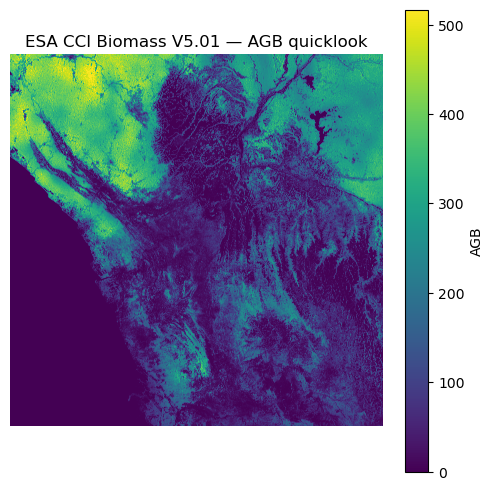

In [7]:
if r.status_code == 200:
    with MemoryFile(r.content) as mem:
        with mem.open() as ds:
            arr = ds.read(1)  # first band
            prof = ds.profile

    valid = arr[np.isfinite(arr)]
    if valid.size == 0:
        raise RuntimeError("No valid pixels found in the selected asset.")

    print("Shape:", arr.shape)
    print("CRS:", prof.get("crs"))
    print("Transform:", prof.get("transform"))
    print("Min/Max:", float(np.nanmin(valid)), float(np.nanmax(valid)))

    plt.imshow(arr, vmin=np.nanpercentile(valid, 2), vmax=np.nanpercentile(valid, 98))
    plt.title("ESA CCI Biomass V5.01 — AGB quicklook")
    plt.colorbar(label="AGB")
    plt.axis("off")


## Using Rasterio for Data Access

The below cell shows another method to load the data directly with Rasterio by passing the token in GDAL HTTP headers.

In [8]:
# Works if your GDAL/Rasterio build supports HTTP headers with /vsicurl/.
rio_env = rasterio.Env(GDAL_HTTP_HEADERS=f"Authorization: Bearer {ESA_TOKEN}")
with rio_env:
    with rasterio.open(V5_EXAMPLE_URL) as ds:
        a = ds.read(1)
        print("Loaded via rasterio+headers:", a.shape)

Loaded via rasterio+headers: (11250, 11250)


## Downloading File Locally

Here we define a helper function to save authenticated downloads to disk for later use.

In [9]:
def save_auth_file(url: str, token: str, out_path: str, chunk: int = 1 << 20) -> str:
    headers = {"Authorization": f"Bearer {token}"}
    with requests.get(url, headers=headers, stream=True) as resp:
        resp.raise_for_status()
        with open(out_path, "wb") as f:
            for part in resp.iter_content(chunk_size=chunk):
                if part:
                    f.write(part)
    return out_path

# Example:
save_auth_file(V5_EXAMPLE_URL, ESA_TOKEN, "cci_biomass_v5_example.tif")


'cci_biomass_v5_example.tif'

The example CCI V5 tile is succesfully downloaded locally. 